In [1]:
import os
import torch
import numpy as np
from torch import nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

# Constants
Z_DIMS = 16
H_DIMS = 32
N_CHANNELS = 1               # We want to generate a black and white image.
DEVICE = "cuda"               # Make sure to enable gpu.
IMG_DIMS = 28                # Size of the image
LEARNING_RATE = 2e-4         # Learning rate of the Networks

# Additional optimizer parameters.
beta_1 = 0.5
beta_2 = 0.999

In [3]:
class Generator(nn.Module):


    def __init__(self, z_dim: int = Z_DIMS, hidden_dims: int = H_DIMS, image_channels: int = N_CHANNELS) -> None:

        super(Generator, self).__init__()

        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dims * 4, kernel_size=3),
            self.gen_block(hidden_dims * 4, hidden_dims * 2, stride=1),
            self.gen_block(hidden_dims * 2, hidden_dims, kernel_size=3),
            self.gen_block(hidden_dims, image_channels, output_layer=True)
        )

    def gen_block(self, in_dims: int, out_dims: int, kernel_size: int = 4, stride: int = 2, output_layer: bool = False):

        if not output_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_dims, out_dims, kernel_size, stride),
                nn.BatchNorm2d(out_dims),
                nn.LeakyReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_dims, out_dims, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, noise):
        noise = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)
def generate_noise(samples: int, z_dim: int = Z_DIMS, device=DEVICE):

    return torch.randn(samples, z_dim, device=device)

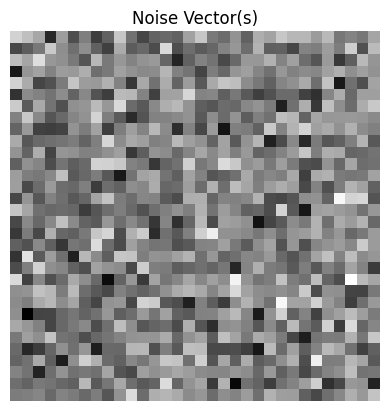

In [4]:
noise = generate_noise(32, z_dim=32, device="cpu")

# Visual the Noise Vector
plt.title("Noise Vector(s)")
plt.imshow(noise, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
# Initialize the generator
base_gen = Generator()

# Generate noise vector
noise = generate_noise(10, device='cpu')

# Model generated images from noise vector
synthetic_images = base_gen(noise)

In [6]:
def show_generations(generations, n_rows, n_cols, figsize=(8, 5), title=None, save_loc=None):

    synthetic_images = generations.view(-1, IMG_DIMS, IMG_DIMS, N_CHANNELS).detach().cpu()

    plt.figure(figsize=figsize)
    plt.suptitle("Synthetic Images" if title is None else title)

    for index in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(synthetic_images[index], cmap='gray')
        plt.axis('off')

    if save_loc is not None:
        if not os.path.exists(os.path.dirname(save_loc)):
            os.makedirs(os.path.dirname(save_loc))
        plt.savefig(save_loc)

    plt.show()

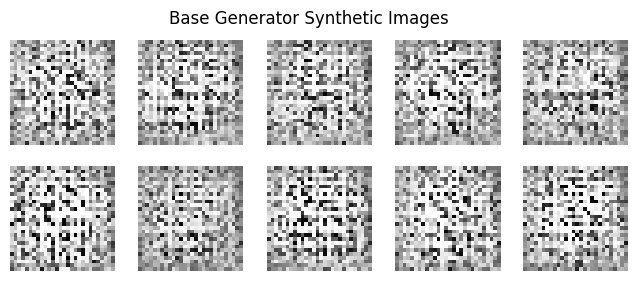

In [7]:
show_generations(
    synthetic_images, 2, 5,
    figsize=(8, 3),
    title="Base Generator Synthetic Images",
    save_loc="./Images/base_generations.png"
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, image_channels: int = N_CHANNELS, hidden_dims: int = 16):

        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            self.disc_block(image_channels, hidden_dims),
            self.disc_block(hidden_dims, hidden_dims * 2),
            self.disc_block(hidden_dims * 2, 1, output_layer=True),
        )

    def disc_block(self, in_dims: int, out_dims: int, kernel_size: int = 4, strides: int = 2, output_layer: bool = False):

        if not output_layer:
            return nn.Sequential(
                nn.Conv2d(in_dims, out_dims, kernel_size, strides),
                nn.BatchNorm2d(out_dims),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_dims, out_dims, kernel_size, strides)
            )

    def forward(self, images):
        return self.disc(images).view(len(images), -1)

In [9]:
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# Initialize the optimizers, respectively.
gen_opt = torch.optim.Adam(generator.parameters(), lr = LEARNING_RATE, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr = LEARNING_RATE, betas=(beta_1, beta_2))

In [10]:
BATCH_SIZE = 8                                     
criterion = nn.BCEWithLogitsLoss()

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Initialize the data loader.
dataloader = DataLoader(
    MNIST('.', download = True, transform = transform),
    batch_size = BATCH_SIZE,
    shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:12<00:00, 763749.88it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 125054.79it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:02<00:00, 594927.47it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 911726.67it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|                                                                                         | 0/7500 [00:00<?, ?it/s]

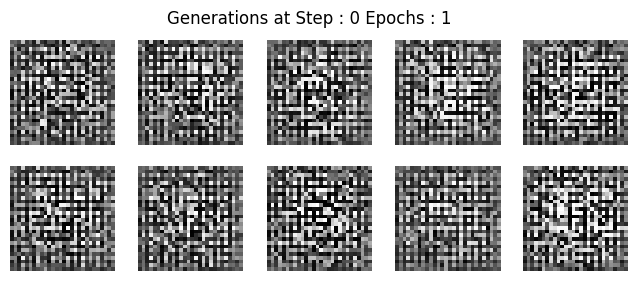

 13%|██████████▌                                                                    | 998/7500 [00:19<01:23, 77.77it/s]

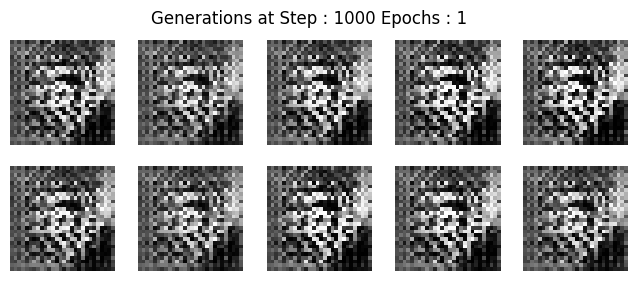

 27%|████████████████████▊                                                         | 2000/7500 [00:34<01:39, 55.24it/s]

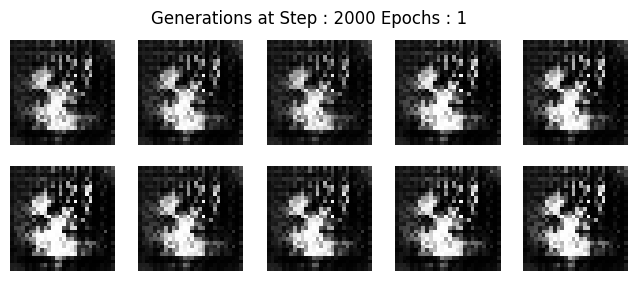

 40%|███████████████████████████████▏                                              | 2995/7500 [00:49<00:52, 85.62it/s]

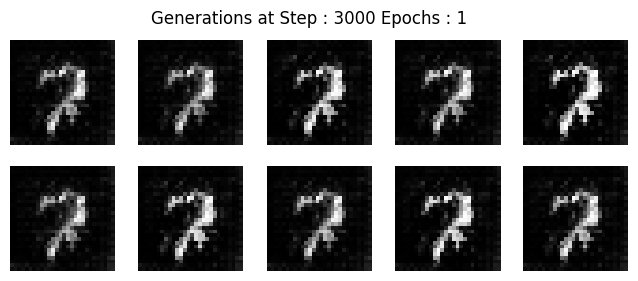

 53%|█████████████████████████████████████████▌                                    | 3998/7500 [01:05<01:04, 54.16it/s]

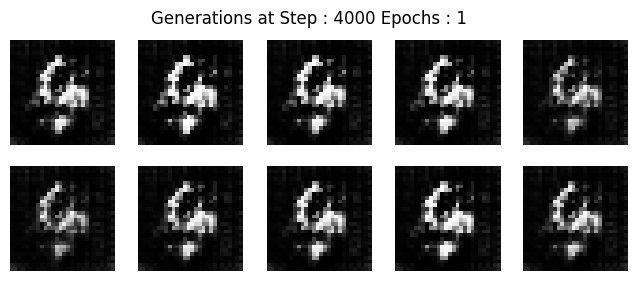

 67%|███████████████████████████████████████████████████▉                          | 4995/7500 [01:20<00:33, 75.88it/s]

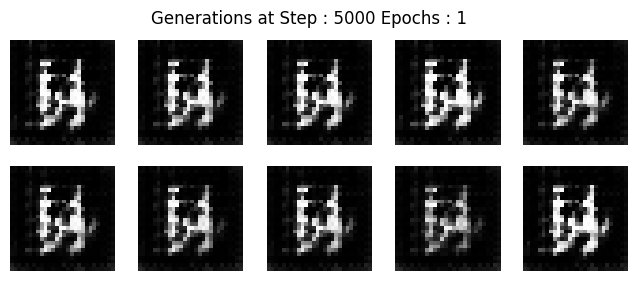

 80%|██████████████████████████████████████████████████████████████▍               | 5998/7500 [01:35<00:20, 71.87it/s]

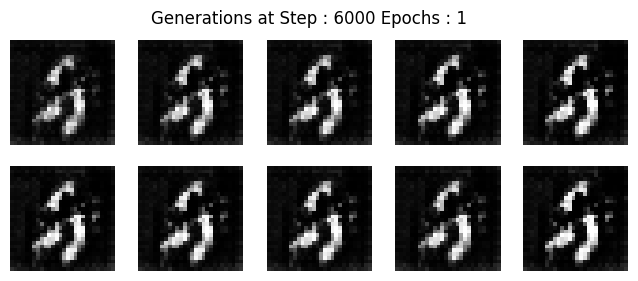

 93%|████████████████████████████████████████████████████████████████████████▊     | 7000/7500 [01:55<00:12, 40.33it/s]

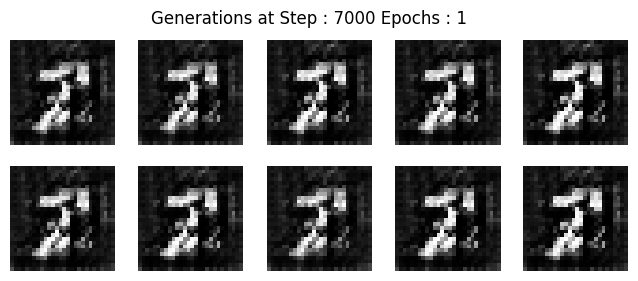

  0%|                                                                                         | 0/7500 [00:00<?, ?it/s]

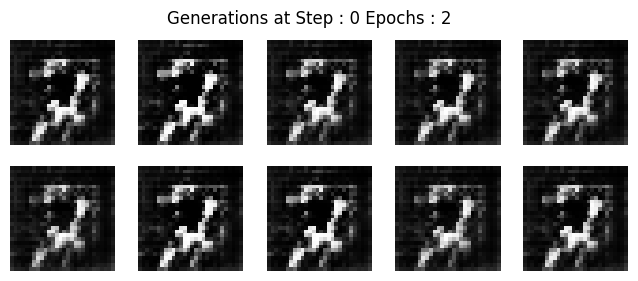

 13%|██████████▌                                                                    | 998/7500 [00:20<02:09, 50.04it/s]

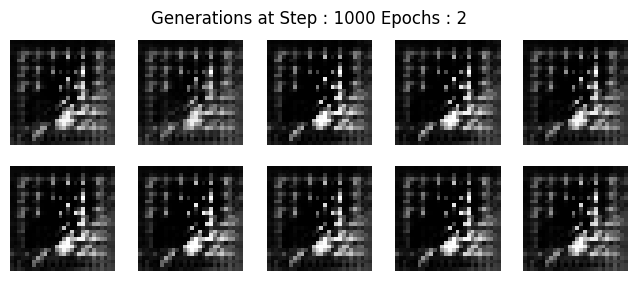

 27%|████████████████████▊                                                         | 1997/7500 [00:36<01:19, 69.32it/s]

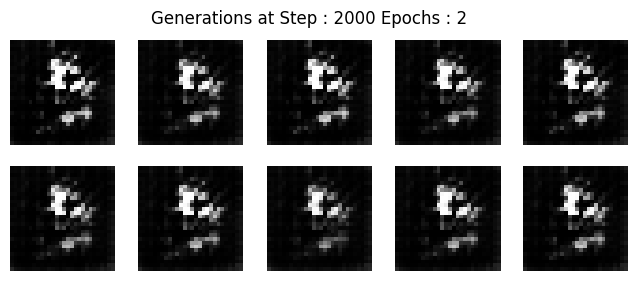

 40%|███████████████████████████████▏                                              | 2994/7500 [00:52<01:15, 59.97it/s]

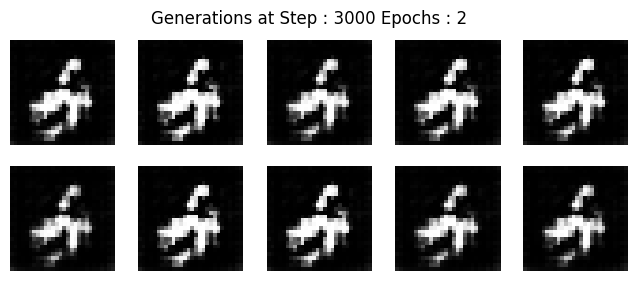

 53%|█████████████████████████████████████████▌                                    | 3996/7500 [01:08<00:38, 91.51it/s]

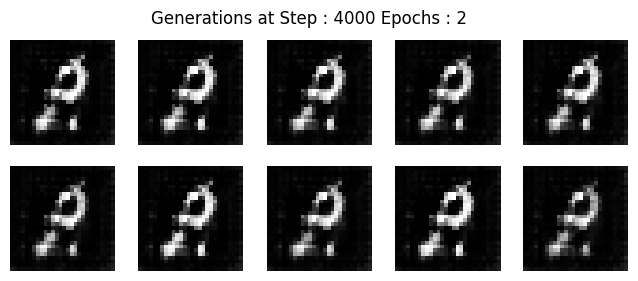

 67%|███████████████████████████████████████████████████▉                          | 4994/7500 [01:23<00:34, 73.03it/s]

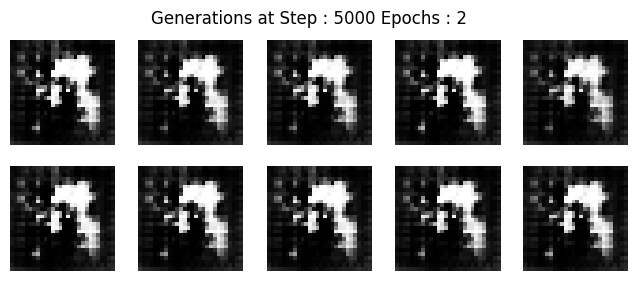

 80%|██████████████████████████████████████████████████████████████▎               | 5995/7500 [01:40<00:27, 55.09it/s]

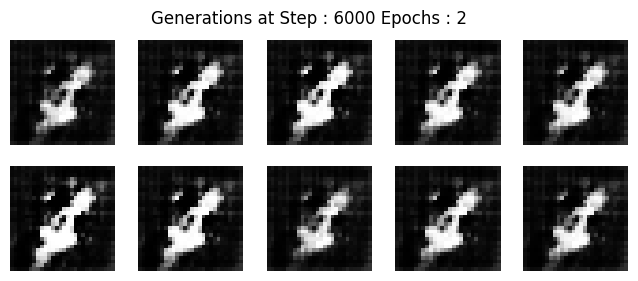

 93%|████████████████████████████████████████████████████████████████████████▊     | 6999/7500 [02:01<00:12, 40.21it/s]

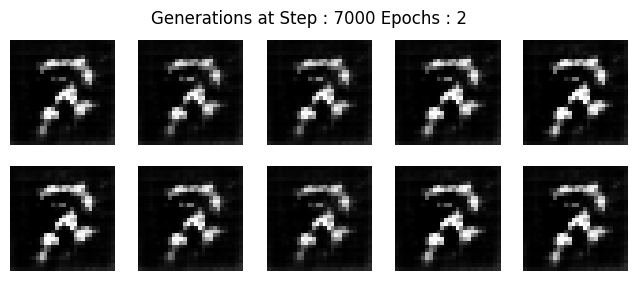

  0%|                                                                                         | 0/7500 [00:00<?, ?it/s]

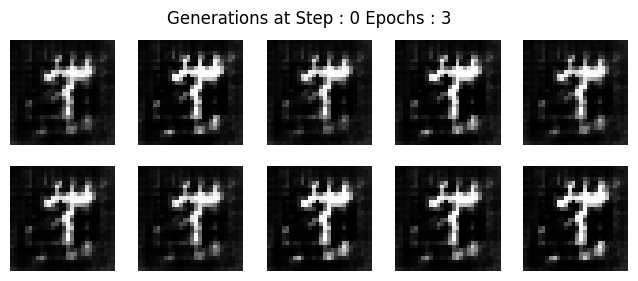

 13%|██████████▌                                                                    | 998/7500 [00:19<01:36, 67.38it/s]

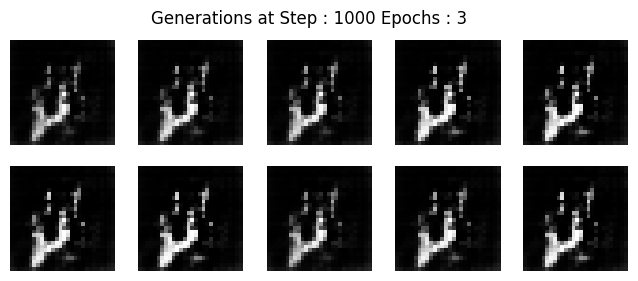

 27%|████████████████████▊                                                         | 1996/7500 [00:35<01:29, 61.55it/s]

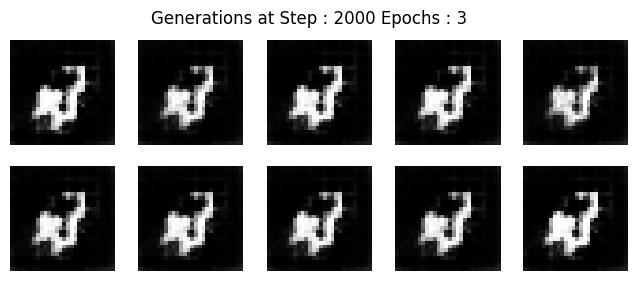

 40%|███████████████████████████████▏                                              | 2994/7500 [00:51<00:58, 76.46it/s]

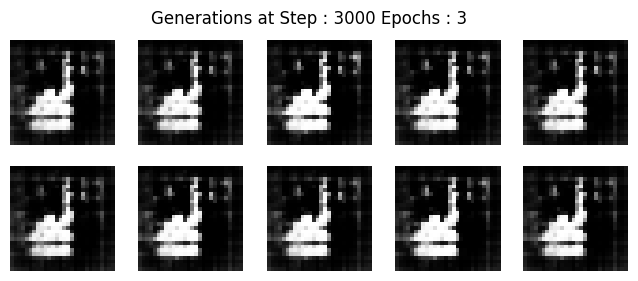

 53%|█████████████████████████████████████████▌                                    | 3998/7500 [01:08<01:01, 56.87it/s]

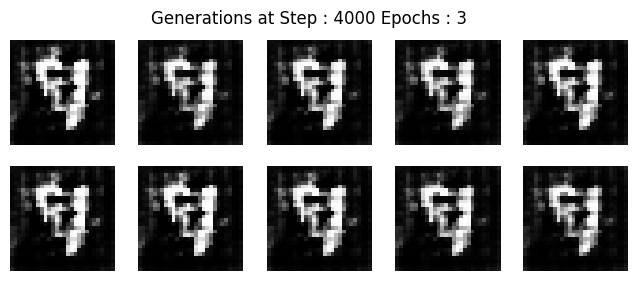

 67%|████████████████████████████████████████████████████                          | 5000/7500 [01:25<00:55, 45.05it/s]

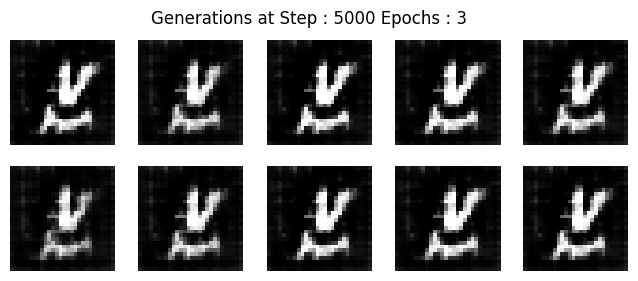

 80%|██████████████████████████████████████████████████████████████▍               | 5999/7500 [01:42<00:24, 60.48it/s]

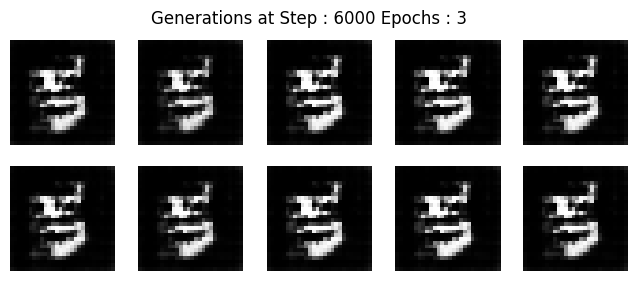

 93%|████████████████████████████████████████████████████████████████████████▊     | 6998/7500 [02:01<00:09, 51.88it/s]

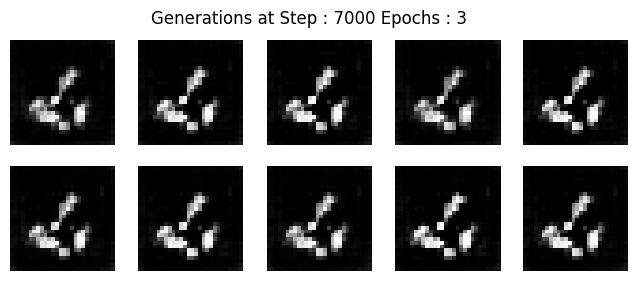

  0%|                                                                                         | 0/7500 [00:00<?, ?it/s]

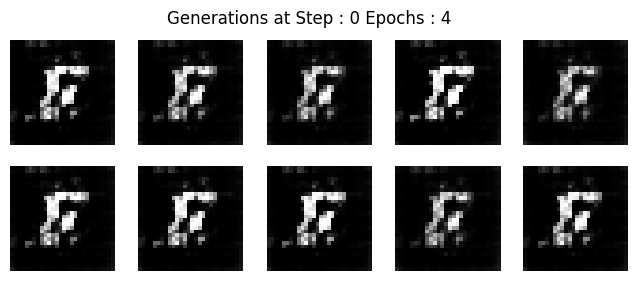

 13%|██████████▍                                                                    | 996/7500 [00:16<02:08, 50.58it/s]

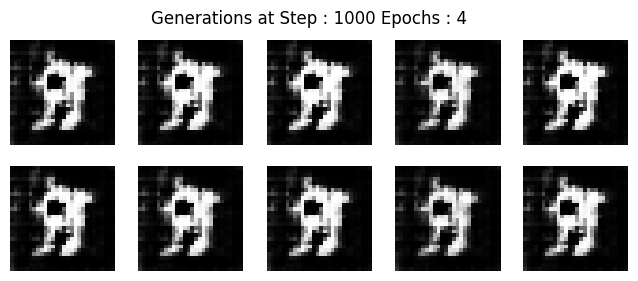

 23%|██████████████████▎                                                           | 1756/7500 [00:29<01:16, 75.00it/s]

In [ ]:
EPOCHS = 10
STEP_SIZE = 1000

# Starting the training loop
for epoch in range(EPOCHS):

    # Maintaining the loss per step
    step_size = 0

    for real, _ in tqdm(dataloader):

        # Collect to the current batch size.
        curr_batch_size = len(real)
        real = real.to(DEVICE)

        ## Training the Discriminator
        disc_opt.zero_grad()

        # Discriminator on the generated images.
        noise_samples = generate_noise(samples = curr_batch_size)
        synthetic_images = generator(noise_samples)
        disc_syn_preds = discriminator(synthetic_images.detach())

        # Discriminator on the real images.
        disc_real_preds = discriminator(real)

        # Average discriminator loss
        disc_syn_loss = criterion(disc_syn_preds, torch.zeros_like(disc_syn_preds))
        disc_real_loss = criterion(disc_real_preds, torch.ones_like(disc_real_preds))
        discriminator_loss = (disc_syn_loss + disc_real_loss) / 2

        discriminator_loss.backward(retain_graph=True)
        disc_opt.step()

        ## Training the Generator
        gen_opt.zero_grad()

        noise_samples = generate_noise(samples = curr_batch_size)
        synthetic_images = generator(noise_samples)
        disc_syn_preds = discriminator(synthetic_images)

        generator_loss = criterion(disc_syn_preds, torch.ones_like(disc_syn_preds))
        generator_loss.backward()
        gen_opt.step()

        # Visualized generations after certain step.
        if (step_size % STEP_SIZE == 0):
            noise_vector = generate_noise(10)
            generations = generator(noise_vector)
            show_generations(
                generations, 2, 5,
                figsize=(8, 3),
                title = f"Generations at Step : {step_size} Epochs : {epoch+1}",
                save_loc = f"./Images/training_gen_{step_size}_epoch_{epoch+1}.png"
            )

        # Increment the step size
        step_size += 1

In [ ]:
noise = generate_noise(50)
syn_images = generator(noise)

# Show Generated Images
show_generations(
    syn_images, 5, 10,
    figsize=(20, 10),
    title="Final Model Generations"
)